# Using Long short term memory networks for streamflow prediction

Refrence links:


1. [Single basin LSTM](https://github.com/kratzert/pangeo_lstm_example)
2. [Neural Hydrology](https://neuralhydrology.github.io)
3.  [EA-LSTM](https://github.com/kratzert/ealstm_regional_modeling)
4. [Prediction in ungauged basins](https://github.com/kratzert/lstm_for_pub)

Please make your own copy of this notebook and work on your copy. Each section can then be merged after discussion in this final notebook.

# **Import Libraries**

# 1) Data download, loading and exploration
Start by downloading CAMELS data, loading into notebook and exploring attributes in this format:

| Basin_ID | Date | Precip | Climate | Vegetation | Topography | Soil | Geology | Streamflow |
|----------|----------|----------|----------|----------|----------|----------|----------|----------|





In [34]:
root_folder = '/mh1/Atakallou/MLproject'
discharge_files = glob.glob(f'{root_folder}/basin_dataset_public_v1p2/usgs_streamflow/*/*.txt')
forcing_files = glob.glob(f'{root_folder}/basin_dataset_public_v1p2/basin_mean_forcing/nldas/*/*.txt')

In [35]:
forcings=[]
for f in forcing_files:
    gaugeid = int(f.split('/')[-1].split('_')[0])
    df = pd.read_csv(f,delimiter='\\s+',skipinitialspace=True,skiprows=3)
    df.insert(0, 'gauge_id', gaugeid)
    forcings.append(df)
    
forcing = pd.concat(forcings,ignore_index=True)
dates = (forcing.Year.map(str) + "/" + forcing.Mnth.map(str) + "/" + forcing.Day.map(str))
forcing.insert(0, 'Date', pd.to_datetime(dates, format="%Y/%m/%d"))
forcing.drop(columns=['Year','Mnth','Day','Hr','Dayl(s)'],inplace=True)

In [36]:
attrs = pd.read_csv(f'{root_folder}/camels_topo.txt',delimiter=';')
for attr in ['camels_clim','camels_vege','camels_geol','camels_soil']:
    attrs=pd.merge(attrs,pd.read_csv(f'{root_folder}/{attr}.txt',delimiter=';'),on='gauge_id')
attrs.drop(columns=['gauge_lat', 'gauge_lon', 'high_prec_timing','low_prec_timing','dom_land_cover','geol_1st_class',
                    'geol_2nd_class','area_geospa_fabric','root_depth_50','root_depth_99','geol_porostiy'],
          inplace=True)

In [40]:
Qobss=[]
for f in discharge_files:
    df = pd.read_csv(f,names = ['gauge_id','year','month','day','Qobs','flag'],delimiter=' ',skipinitialspace=True)
    Qobss.append(df)
Qobs = pd.concat(Qobss,ignore_index=True)
dates = (Qobs.year.map(str) + "/" + Qobs.month.map(str) + "/" + Qobs.day.map(str))
Qobs.insert(0, 'Date', pd.to_datetime(dates, format="%Y/%m/%d"))
Qobs.drop(columns=['year','month','day','flag'],inplace=True)

In [41]:
Qobs = Qobs[Qobs['gauge_id'].isin(attrs['gauge_id'].unique())]

In [ ]:
forcing = forcing[forcing['gauge_id'].isin(attrs['gauge_id'].unique())]

In [ ]:
len(forcing.gauge_id.unique())

In [ ]:
(forcing.merge(attrs)).merge(Qobs).to_pickle('/mh1/nkarki/MLproj/CAMELS_data.pkl')

# Single run

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import random
import glob

## Data loading

In [189]:
nldas = glob.glob('/mh1/nkarki/MLproj/nldas/*/*.txt')

In [190]:
forcings=[]
for f in nldas:
    gauge_id = str(f.split('/')[-1].split('_')[0])
    df=pd.read_csv(nldas[0],skiprows=3,sep='\s+')
    df.insert(0, 'gauge_id', gauge_id)
    forcings.append(df)

In [191]:
forcing = pd.concat(forcings)
forcing['Date'] = pd.to_datetime(dict(year=forcing.Year, month=forcing.Mnth, day=forcing.Day))
forcing.drop(columns=['Year','Mnth','Day','Hr','Dayl(s)'],inplace=True)

In [235]:
attr_files = glob.glob('/mh1/nkarki/MLproj/CAMELS_attrs/*.txt')

In [236]:
attr_files

['/mh1/nkarki/MLproj/CAMELS_attrs/camels_vege.txt',
 '/mh1/nkarki/MLproj/CAMELS_attrs/camels_topo.txt',
 '/mh1/nkarki/MLproj/CAMELS_attrs/camels_soil.txt',
 '/mh1/nkarki/MLproj/CAMELS_attrs/camels_hydro.txt',
 '/mh1/nkarki/MLproj/CAMELS_attrs/camels_geol.txt',
 '/mh1/nkarki/MLproj/CAMELS_attrs/camels_clim.txt']

In [237]:
basin_attr = pd.DataFrame()

for f in attr_files:
    df = pd.read_csv(f,sep=';')
    df.set_index('gauge_id',inplace=True)
    if basin_attr.empty:
        basin_attr = df
    else:
        basin_attr = basin_attr.merge(df,left_index=True,right_index=True)

In [21]:
INVALID_ATTR = [
    'area_geospa_fabric', 'geol_1st_class', 'glim_1st_class_frac', 'geol_2nd_class',
    'glim_2nd_class_frac', 'dom_land_cover_frac', 'dom_land_cover', 'high_prec_timing',
    'low_prec_timing', 'q_mean', 'runoff_ratio', 'stream_elas', 'slope_fdc',
    'baseflow_index', 'hfd_mean', 'q5', 'q95', 'high_q_freq', 'high_q_dur', 'low_q_freq',
    'low_q_dur', 'zero_q_freq', 'geol_porostiy', 'root_depth_50', 'root_depth_99', 'organic_frac',
    'water_frac', 'other_frac'
]

In [242]:
basin_attr.drop(columns = INVALID_ATTR,inplace=True)

In [247]:
qobss = glob.glob('/mh1/nkarki/MLproj/usgs_streamflow/*/*.txt')

In [333]:
qobs = []
for f in qobss:
    df = pd.read_csv(f,names=['gauge_id','Year','Month','Day','Qobs','flag'],sep='\s+')
    qobs.append(df)

In [334]:
qobs = pd.concat(qobs)

In [335]:
qobs['Date'] = pd.to_datetime(dict(year=qobs.Year, month=qobs.Month, day=qobs.Day))

In [336]:
qobs

,gauge_id,Year,Month,Day,Qobs,flag,Date
0,1013500,1980,1,1,655.0,A,1980-01-01
1,1013500,1980,1,2,640.0,A,1980-01-02
2,1013500,1980,1,3,625.0,A,1980-01-03
3,1013500,1980,1,4,620.0,A,1980-01-04
4,1013500,1980,1,5,605.0,A,1980-01-05
...,...,...,...,...,...,...,...
12779,11532500,2014,12,27,-999.0,M,2014-12-27
12780,11532500,2014,12,28,-999.0,M,2014-12-28
12781,11532500,2014,12,29,-999.0,M,2014-12-29
12782,11532500,2014,12,30,-999.0,M,2014-12-30


In [337]:
all_basins = basin_attr.index.unique()

In [338]:
qobs = qobs[qobs.gauge_id.isin(all_basins)]

In [340]:
qobs.drop(columns=['Year','Month','Day','flag'])
#qobs.set_index(['gauge_id','Date'],inplace=True)

KeyError: "['Year', 'Month', 'Day', 'flag'] not found in axis"

0         1013500
1         1013500
2         1013500
3         1013500
4         1013500
           ...   
12779    11532500
12780    11532500
12781    11532500
12782    11532500
12783    11532500
Name: gauge_id, Length: 8415489, dtype: int64

## Model

In [2]:
root_dir = '/mh1/nkarki/MLproj'

In [3]:
camels_df = pd.read_pickle(f'{root_dir}/CAMELS_data.pkl')

In [4]:
camels_df.drop(columns=['dom_land_cover_frac',
 'glim_1st_class_frac',
 'glim_2nd_class_frac',
 'organic_frac',
 'water_frac',
 'other_frac'],inplace=True)

In [5]:
camels_df = camels_df[camels_df.Qobs >= 0].sort_values(by=['gauge_id','Date'])

In [6]:
basins = random.sample(sorted(camels_df.gauge_id.unique()),600) 

In [7]:
eligible_basins = [basin for basin in camels_df.gauge_id.unique() if basin not in basins]

In [8]:
test_basins = random.sample(sorted(eligible_basins),71)

In [9]:
df = camels_df[camels_df.gauge_id.isin(basins)]

In [10]:
train_period = pd.date_range('1980-01-01','2008-12-31')
valid_period = pd.date_range('2009-01-01','2014-12-31')
test_period = pd.date_range('1980-01-01','2014-12-31')

In [11]:
train_df = df[df.Date.isin(train_period)]
valid_df = df[df.Date.isin(test_period)]

In [69]:
train_df

,Date,gauge_id,PRCP(mm/day),SRAD(W/m2),Tmax(C),Tmin(C),Vp(Pa),elev_mean,slope_mean,area_gages2,...,geol_permeability,soil_depth_pelletier,soil_depth_statsgo,soil_porosity,soil_conductivity,max_water_content,sand_frac,silt_frac,clay_frac,Qobs
4828739,1980-01-01,1013500,0.00,218.66,-13.04,-13.04,203.28,250.31,21.64152,2252.70,...,-14.7019,7.404762,1.248408,0.461149,1.106522,0.558055,27.841827,55.156940,16.275732,7.113717e+05
4828740,1980-01-02,1013500,0.00,199.05,-10.93,-10.93,237.37,250.31,21.64152,2252.70,...,-14.7019,7.404762,1.248408,0.461149,1.106522,0.558055,27.841827,55.156940,16.275732,6.950807e+05
4828741,1980-01-03,1013500,0.00,197.64,-13.60,-13.60,169.39,250.31,21.64152,2252.70,...,-14.7019,7.404762,1.248408,0.461149,1.106522,0.558055,27.841827,55.156940,16.275732,6.787898e+05
4828742,1980-01-04,1013500,0.00,214.61,-16.53,-16.53,134.57,250.31,21.64152,2252.70,...,-14.7019,7.404762,1.248408,0.461149,1.106522,0.558055,27.841827,55.156940,16.275732,6.733595e+05
4828743,1980-01-05,1013500,0.00,206.02,-17.60,-17.60,129.30,250.31,21.64152,2252.70,...,-14.7019,7.404762,1.248408,0.461149,1.106522,0.558055,27.841827,55.156940,16.275732,6.570685e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6363993,2008-12-27,14400000,29.58,88.11,3.94,3.94,711.01,625.31,98.81802,702.63,...,-14.7163,0.929015,1.071426,0.452074,0.941310,0.494187,30.026587,42.214515,27.805122,2.277245e+07
6363994,2008-12-28,14400000,171.20,105.07,6.59,6.59,829.54,625.31,98.81802,702.63,...,-14.7163,0.929015,1.071426,0.452074,0.941310,0.494187,30.026587,42.214515,27.805122,1.156032e+08
6363995,2008-12-29,14400000,135.26,137.48,6.10,6.10,822.86,625.31,98.81802,702.63,...,-14.7163,0.929015,1.071426,0.452074,0.941310,0.494187,30.026587,42.214515,27.805122,1.344062e+08
6363996,2008-12-30,14400000,0.37,239.88,1.42,1.42,513.03,625.31,98.81802,702.63,...,-14.7163,0.929015,1.071426,0.452074,0.941310,0.494187,30.026587,42.214515,27.805122,5.431960e+07


In [12]:
mean = train_df.mean()
std = train_df.std()

In [13]:
mean[2:]

PRCP(mm/day)                  3.046886
SRAD(W/m2)                  355.815716
Tmax(C)                      10.669536
Tmin(C)                      10.669536
Vp(Pa)                     1054.104318
elev_mean                   767.402097
slope_mean                   46.978654
area_gages2                 803.323061
p_mean                         3.27736
pet_mean                      2.775789
p_seasonality                 -0.04532
frac_snow                     0.182726
aridity                       1.043354
high_prec_freq               20.834066
high_prec_dur                 1.351422
low_prec_freq               254.010328
low_prec_dur                  5.913295
frac_forest                   0.642056
lai_max                       3.197595
lai_diff                      2.426394
gvf_max                       0.722676
gvf_diff                      0.321593
carbonate_rocks_frac          0.121334
geol_permeability           -13.899063
soil_depth_pelletier          11.01097
soil_depth_statsgo       

In [14]:
def create_seq(x,y,seq_length):
        num_samples, num_features = x.shape

        x_new = np.zeros((num_samples - seq_length + 1, seq_length, num_features))
        y_new = np.zeros((num_samples - seq_length + 1, 1))

        for i in range(0, x_new.shape[0]):
            x_new[i, :, :num_features] = x[i:i + seq_length, :]
            y_new[i, :] = y[i + seq_length - 1, 0]
            
        return x_new.astype('float16'), y_new.astype('float16')

In [15]:
X_train = []
y_train = []
for idx,df in train_df.groupby('gauge_id'):
    print(idx)
    df = df.drop(columns=['Date','gauge_id'])
    df = (df - mean[2:])/std[2:]
    X = df.iloc[:,:-1].to_numpy('float32')
    y = df.iloc[:,-1].to_numpy('float32').reshape(-1,1)
    X,y = create_seq(X,y,270)
    X_train.append(X)
    y_train.append(y)

X_valid = []
y_valid = []
for idx,df in valid_df.groupby('gauge_id'):
    print(idx)
    df = df.drop(columns=['Date','gauge_id'])
    df = (df - mean[2:])/std[2:]
    X = df.iloc[:,:-1].to_numpy('float32')
    y = df.iloc[:,-1].to_numpy('float32').reshape(-1,1)
    X,y = create_seq(X,y,270)
    X_valid.append(X)
    y_valid.append(y)

1013500
1022500
1030500
1031500
1047000
1052500
1054200
1055000
1057000
1073000
1118300
1123000
1137500
1139000
1139800
1142500
1144000
1162500
1169000
1170100
1181000
1187300
1195100
1333000
1350000
1350080
1350140
1365000
1411300
1413500
1415000
1434025
1435000
1439500
1440000
1440400
1451800
1484100
1485500
1486000
1487000
1491000
1510000
1516500
1518862
1532000
1539000
1543000
1543500
1544500
1545600
1547700
1548500
1549500
1550000
1552000
1557500
1567500
1568000
1580000
1583500
1586610
1591400
1594950
1596500
1605500
1620500
1632000
1632900
1638480
1644000
1658500
1664000
1666500
1667500
1669000
1669520
2011400
2011460
2013000
2014000
2015700
2016000
2017500
2018000
2027000
2027500
2028500
2038850
2046000
2051000
2051500
2053200
2053800
2055100
2056900
2059500
2064000
2065500
2069700
2070000
2074500
2077200
2081500
2082950
2092500
2096846
2108000
2111180
2111500
2112120
2112360
2118500
2125000
2137727
2140991
2143040
2152100
2177000
2178400
2193340
2196000
2198100
2202600
2212600


In [16]:
test_df = camels_df[camels_df.gauge_id.isin(test_basins)]

In [17]:
X_test = []
y_test = []
for idx,df in test_df.groupby('gauge_id'):
    print(idx)
    df = df.drop(columns=['Date','gauge_id'])
    df = (df - mean[2:])/std[2:]
    X = df.iloc[:,:-1].to_numpy('float32')
    y = df.iloc[:,-1].to_numpy('float32').reshape(-1,1)
    X,y = create_seq(X,y,270)
    X_test.append(X)
    y_test.append(y)

1078000
1121000
1134500
1414500
1423000
1466500
1542810
1552500
1606500
1613050
1634500
1639500
2102908
2128000
2143000
2149000
2314500
2342933
2363000
2472500
2481510
3028000
3076600
3187500
3281500
3285000
3338780
3384450
3456500
3471500
3498500
3500240
3574500
4015330
4216418
4256000
5120500
5131500
5291000
5495500
6221400
6332515
6453600
6889200
7060710
7066000
7149000
7167500
7292500
7295000
7301500
8013000
8158810
8164300
8171300
8267500
9430500
9430600
9480000
9508300
9513780
10259200
10336645
11180500
11180960
11284400
12377150
13083000
13161500
14137000
14305500


In [18]:
X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)
X_valid = np.concatenate(X_valid)
y_valid = np.concatenate(y_valid)

In [19]:
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

In [30]:
X_train.shape

(6046988, 270, 32)

In [20]:
class CAMELS(Dataset):
    def __init__(self,X,y=None):
        self.X = torch.from_numpy(X.copy()).float()
        self.y = torch.from_numpy(y.copy()).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self,idx:int):
        return self.X[idx],self.y[idx]

In [21]:
train_data = CAMELS(X_train,y_train)
valid_data = CAMELS(X_valid,y_valid)
train_loader = DataLoader(train_data, batch_size=120, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=120, shuffle=False)

In [22]:
test_data = CAMELS(X_test,y_test)
test_loader = DataLoader(test_data,batch_size=2000,shuffle=False)

64

# Model
To do:
1) LSTM model
2) Train and val loop
3) Test loop

In [23]:
class Model(nn.Module):
    """Implementation of a single layer LSTM network"""
    
    def __init__(self, hidden_size: int, dropout_rate: float=0.0):
        """Initialize model
        
        :param hidden_size: Number of hidden units/LSTM cells
        :param dropout_rate: Dropout rate of the last fully connected
            layer. Default 0.0
        """
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate
        
        # create required layer
        self.lstm = nn.LSTM(input_size=32, hidden_size=self.hidden_size, 
                            num_layers=1, bias=True, batch_first=True)
        self.dropout = nn.Dropout(p=self.dropout_rate)
        self.fc = nn.Linear(in_features=self.hidden_size, out_features=1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the Network.
        
        :param x: Tensor of shape [batch size, seq length, num features]
            containing the input data for the LSTM network.
        
        :return: Tensor containing the network predictions
        """
        output, (h_n, c_n) = self.lstm(x)
        
        # perform prediction only at the end of the input sequence
        pred = self.fc(self.dropout(h_n[-1,:,:]))
        return pred

In [24]:
def NSELoss(y_pred,y_true):
    squared_error = (y_pred - y_true)**2
    weights = 1 / (std.iloc[-1]+0.1)**2
    scaled_loss = weights * squared_error
    return torch.mean(scaled_loss)

In [25]:
def train_epoch(model, optimizer, loader, loss_func, epoch):
    """Train model for a single epoch.

    :param model: A torch.nn.Module implementing the LSTM model
    :param optimizer: One of PyTorchs optimizer classes.
    :param loader: A PyTorch DataLoader, providing the trainings
        data in mini batches.
    :param loss_func: The loss function to minimize.
    :param epoch: The current epoch (int) used for the progress bar
    """
    # set model to train mode (important for dropout)
    model.to(DEVICE)
    model.train()
    pbar = tqdm.tqdm_notebook(loader)
    pbar.set_description(f"Epoch {epoch}")
    # request mini-batch of data from the loader
    for xs, ys in pbar:
        # delete previously stored gradients from the model
        optimizer.zero_grad()
        # push data to GPU (if available)
        xs, ys = xs.to(DEVICE), ys.to(DEVICE)
        # get model predictions
        y_hat = model(xs)
        # calculate loss
        loss = loss_func(y_hat, ys)
            
        # calculate gradients
        loss.backward()
        # update the weights
        optimizer.step()
        # write current loss in the progress bar
        pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

        
def eval_model(model, loader):
    """Evaluate the model.

    :param model: A torch.nn.Module implementing the LSTM model
    :param loader: A PyTorch DataLoader, providing the data.
    
    :return: Two torch Tensors, containing the observations and 
        model predictions
    """
    # set model to eval mode (important for dropout)
    model.to(DEVICE)
    model.eval()
    obs = []
    preds = []
    # in inference mode, we don't need to store intermediate steps for
    # backprob
    with torch.no_grad():
        # request mini-batch of data from the loader
        for xs, ys in loader:
            # push data to GPU (if available)
            xs = xs.to(DEVICE)
            # get model predictions
            y_hat = model(xs)
            obs.append(ys)
            preds.append(y_hat)
            
    return torch.cat(obs), torch.cat(preds)

In [26]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # This line checks if GPU is available
DEVICE

device(type='cuda', index=0)

In [27]:
model = Model(hidden_size = 128, dropout_rate= 0.4)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = nn.MSELoss()

In [28]:
n_epochs = 100 # Number of training epochs

for i in range(n_epochs):
    train_epoch(model, optimizer, train_loader, criterion, i+1)

/state/partition1/5226480/ipykernel_81708/1064952264.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm.tqdm_notebook(loader)


  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

  0%|          | 0/50339 [00:00<?, ?it/s]

In [29]:
obs, preds = eval_model(model, valid_loader)
obs = obs.detach().to('cpu').numpy()
preds = preds.detach().to('cpu').numpy()

In [30]:
obs = (obs*std.iloc[-1])+mean.iloc[-1]
preds = (preds*std.iloc[-1])+mean.iloc[-1]

In [31]:
pred_df = valid_df.groupby('gauge_id').tail(-269)
pred_df = pred_df[['Date','gauge_id']]
pred_df['Qobs'] = obs.flatten()
pred_df['Qsim'] = preds.flatten()

In [ ]:
pred_df

In [32]:
pred_df.to_csv('/bighome/nkarki/lstm_preds_all_100.csv')

In [40]:
pred_df = pd.read_csv('/bighome/nkarki/lstm_preds_all_100.csv')

In [41]:
def calc_nse(obs, sim):
    denominator = np.sum((obs - np.mean(obs)) ** 2)
    numerator = np.sum((sim - obs) ** 2)
    nse_val = 1 - numerator / denominator

    return nse_val

In [42]:
ids = []
NSE = []
for idx,df in pred_df.groupby('gauge_id'):
    ids.append(idx)
    nse = calc_nse(df.Qobs,df.Qsim)
    NSE.append(nse)
    print(idx,nse)

1013500 0.7130600568990177
1022500 0.7520838333623767
1030500 0.7070525113639305
1031500 0.776310980217531
1047000 0.7585205031979714
1052500 0.7978367795355309
1054200 0.6829113315373356
1055000 0.6802042506101187
1057000 0.7360100314955308
1073000 0.7730042310940364
1118300 0.7266643569581717
1123000 0.7518308271998501
1137500 0.7359242844995246
1139000 0.6973914625906992
1139800 0.6441284307477451
1142500 0.6712183473547098
1144000 0.730280023180949
1162500 0.7228195548020135
1169000 0.7466143291490525
1170100 0.7717372341753397
1181000 0.7410244722641295
1187300 0.7774289041184068
1195100 0.7152146394295182
1333000 0.7540865995020075
1350000 0.7641044741581697
1350080 0.6805181227144483
1350140 0.6651063555126897
1365000 0.8039752688082502
1411300 0.584531693584401
1413500 0.7844888146370416
1415000 0.7702879612478277
1434025 0.7836894798628444
1435000 0.8006714516432373
1439500 0.7066803408059914
1440000 0.7431251823324003
1440400 0.7756965237509315
1451800 0.5701088035220692
1484

In [45]:
ids[np.argmax(NSE)]

14306500

(0.0, 1.0)

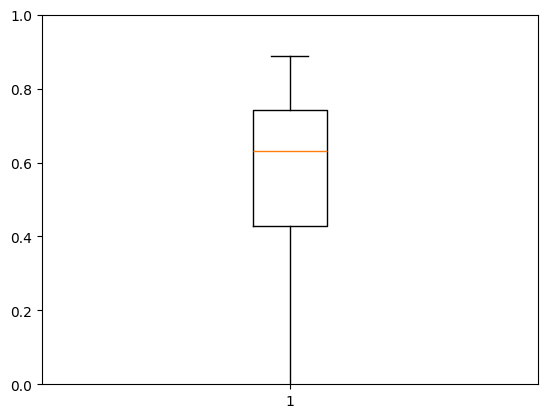

In [43]:
plt.boxplot(NSE)
plt.ylim(0, 1)

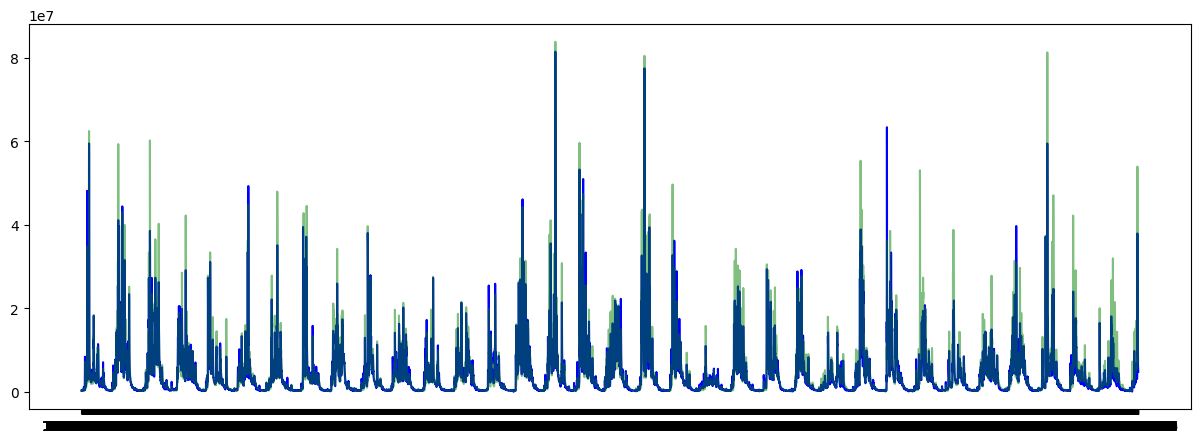

In [47]:
plot_df = pred_df[pred_df.gauge_id == 14306500]
plt.figure(figsize=(15, 5))  # Set the figure size

# Plot line plot for column1
plt.plot(plot_df.Date, plot_df.Qsim, label='Qsim',color='blue')
#plt.scatter(plot_df.Date, plot_df.Qsim, label='Qsim', color='blue',marker='o',facecolors='none', s=20)
# Plot line plot for column2
plt.plot(plot_df.Date, plot_df.Qobs, label='Qobs', color='green',alpha=0.5)

## PUB predictions

In [33]:
obs, preds = eval_model(model, test_loader)
obs = obs.detach().to('cpu').numpy()
pub_preds = preds.detach().to('cpu').numpy()

In [34]:
obs = (obs*std.iloc[-1])+mean.iloc[-1]
pub_preds = (pub_preds*std.iloc[-1])+mean.iloc[-1]

In [535]:
pd.to_datetime('1980-01-01') + pd.Timedelta(days=269)

Timestamp('1980-09-26 00:00:00')

In [35]:
pred_df = test_df.groupby('gauge_id').tail(-269)
pred_df = pred_df[['Date','gauge_id']]
pred_df['Qobs'] = obs.flatten()
pred_df['Qsim'] = pub_preds.flatten()

In [36]:
pred_df.to_csv('/bighome/nkarki/pub_eval_100.csv')

In [55]:
pred_df=pd.read_csv('/bighome/nkarki/pub_eval_100.csv')

In [49]:
ids = []
NSE = []
for idx,df in pred_df.groupby('gauge_id'):
    ids.append(idx)
    nse = calc_nse(df.Qobs,df.Qsim)
    NSE.append(nse)
    print(idx,nse)

1078000 0.7220457358383786
1121000 0.7255776329708491
1134500 0.6453081799719286
1414500 0.7587747679662192
1423000 0.7814221996473449
1466500 -0.720169403847704
1542810 0.692369455934727
1552500 0.7517455587626233
1606500 0.6744887026525876
1613050 0.676842842745709
1634500 0.6709483558470625
1639500 -0.15760037494404244
2102908 0.28432394580178666
2128000 0.5018322216421087
2143000 0.6952343807433585
2149000 0.5675533367299744
2314500 0.45913314240676706
2342933 0.5370548783668708
2363000 0.5778791854630196
2472500 0.5825241143860309
2481510 0.613163158355386
3028000 0.7112737253111128
3076600 0.633100151668874
3187500 0.6867098961974457
3281500 0.7238474314509259
3285000 0.6596948346977772
3338780 0.38827693653331874
3384450 0.6666863639955527
3456500 0.7436842584694319
3471500 0.5376641781312703
3498500 0.8309297809372514
3500240 0.725087494547432
3574500 0.49727075302542656
4015330 0.3459479190497312
4216418 0.6042394715049383
4256000 0.6552463228878589
5120500 -2.8466928402014204

(0.0, 1.0)

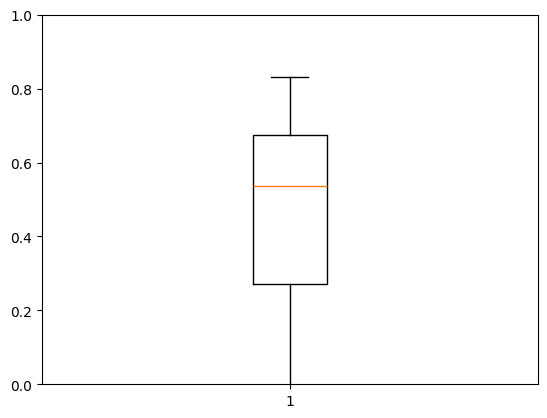

In [50]:
plt.boxplot(NSE)
plt.ylim(0, 1)

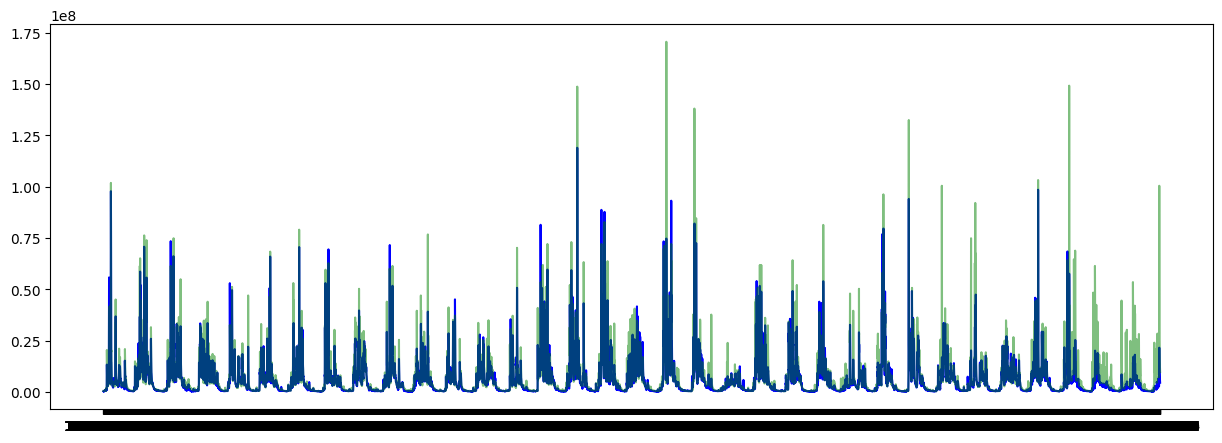

In [56]:
plot_df = pred_df[pred_df.gauge_id == 14305500]

plt.figure(figsize=(15, 5))  # Set the figure size
# Plot line plot for column1
plt.plot(plot_df.Date, plot_df.Qsim, label='Qsim',color='blue')
#plt.scatter(plot_df.Date, plot_df.Qsim, label='Qsim', color='blue',marker='o',facecolors='none', s=20)
# Plot line plot for column2
plt.plot(plot_df.Date, plot_df.Qobs, label='Qobs', color='green',alpha=0.5)